# Aggregate Benefits: Travel Time and Reliability

## Setup

In [1]:
library(RSQLCipher)
suppressMessages(library(lubridate))
suppressWarnings(suppressMessages(library(tidyverse)))
suppressWarnings(suppressMessages(library(lme4)))
suppressWarnings(suppressMessages(library(boot)))
suppressWarnings(suppressMessages(library(rstanarm)))

# import income functions
suppressMessages(source("../../src/income.R"))

select = dplyr::select

In [2]:
Sys.setenv("SQL_KEY"=Sys.getenv("HOT_KEY"))
options(repr.plot.width=10, repr.plot.height=6, scipen=8)

In [3]:
acs = read_csv("../../data/acs/block_group_census_estimates_wide_wsdot_bins.csv", col_types="dccciiddddddddddddddddddd") %>%
    filter(mean_inc < Inf) %>%
    mutate(fips = fips_code) %>% select(-fips_code)
acs_bins = c(0, 20, 35, 50, 75, 100, 125, 150, 200, Inf)

In [4]:
db_path = "../../../data/hot.db"
trips_raw = load_table(db_path, "trips_linked")
#acs = load_table(db_path, "acs")
sp_vol = load_table(db_path, "sp_vol")
tt = load_table(db_path, "travel_times")
rel = load_table(db_path, "reliability")

In [5]:
reliability = suppressMessages(read_csv("../../data/benefits/expected_reliability_savings.csv"))
entries_raw = suppressMessages(read_csv("../../data/benefits/trips_gate_time.csv")) %>%
    mutate(trip_id = sprintf("%02i_%02i", entry, exit),
               tod_20 = floor(tod/20)*20) %>%
    filter(GP_volume >= 0, HOT_volume >= 0, savings >= -20) %>%
    drop_na(savings, HOT_speed, GP_speed, HOT_volume, GP_volume)

## Travel time savings

In [6]:
savings.m = lm(savings ~ (toll + HOT_speed + GP_speed + GP_volume + HOT_volume)*as.factor(entry)
               + trip_id + as.factor(tod_20),  data=entries_raw, model=F)

In [7]:
broom::glance(savings.m)

r.squared,adj.r.squared,sigma,statistic,p.value,df,logLik,AIC,BIC,deviance,df.residual
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
0.6814197,0.6810455,0.04032618,1820.995,0,204,310140,-619869.9,-617807.4,281.0498,172826


In [8]:
broom::glance(savings.m)

r.squared,adj.r.squared,sigma,statistic,p.value,df,logLik,AIC,BIC,deviance,df.residual
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
0.6825084,0.6821042,0.0402592,1688.571,0,221,310436.1,-620428.2,-618194.6,280.0893,172809


In [8]:
entries_raw$est_savings = predict(savings.m, newdata=entries_raw)

Warning message in predict.lm(savings.m, newdata = entries_raw):
“prediction from a rank-deficient fit may be misleading”

In [9]:
rm(savings.m)
gc()

,used,(Mb),gc trigger,(Mb),limit (Mb),max used,(Mb)
Ncells,2615129,139.7,5208327,278.2,NA,3977224,212.5
Vcells,7813956,59.7,100260848,765.0,16384,122235686,932.6


## Joining

In [10]:
trip_length_lookup = suppressMessages(read_csv("../../data/milepost_lookups/trip_length_lookup.csv"))

In [243]:
entries = entries_raw %>%
    mutate(tod_5 = round(tod/5)*5,
           tod_20 = floor(tod/20)*20,
           direction = if_else(entry <= 12, "NB", "SB"),
           entry_plaza = if_else(direction=="NB", entry-2, entry-12),
           exit_plaza = if_else(direction=="NB", exit-2, exit-12),
           inc = mean_inc/1000, # center around median income for user
           date_time = as_datetime(date_time),
           hour = hour(date_time),
           date = date(date_time),
           am_peak = hour >= 5 & hour < 9,
           pm_peak = hour >= 15 & hour < 19,
           peak = am_peak | pm_peak,
           peak_group = case_when(am_peak & direction=="SB" ~ "AM peak SB",
                             pm_peak & direction=="NB" ~ "PM peak NB",
                             am_peak & direction=="NB" ~ "Reverse commute",
                             pm_peak & direction=="SB" ~ "Reverse commute",
                             T ~ "Off-peak"),
           dir_group = case_when(am_peak & direction=="SB" ~ "AM peak",
                             pm_peak & direction=="NB" ~ "PM peak",
                             T ~ "Off-peak"),
           is.holiday = date %in% ymd(c("2018-01-01", "2018-01-15", "2018-02-19",
                            "2018-05-28", "2018-07-04", "2018-09-03",
                            "2018-10-08", "2018-11-12", "2018-11-22",
                            "2018-11-23", "2018-12-25")),
           group=paste(direction, peak_group)) %>%
    #filter(!is.holiday) %>%
    left_join(reliability, by=c("tod_5"="tod", "entry", "exit", "trip_id")) %>%
    left_join(trip_length_lookup, by=c("entry", "exit")) %>%
    drop_na(toll, savings, reliability) %>%
    arrange(date_time)

In [12]:
nrow(entries)

[1] 167254

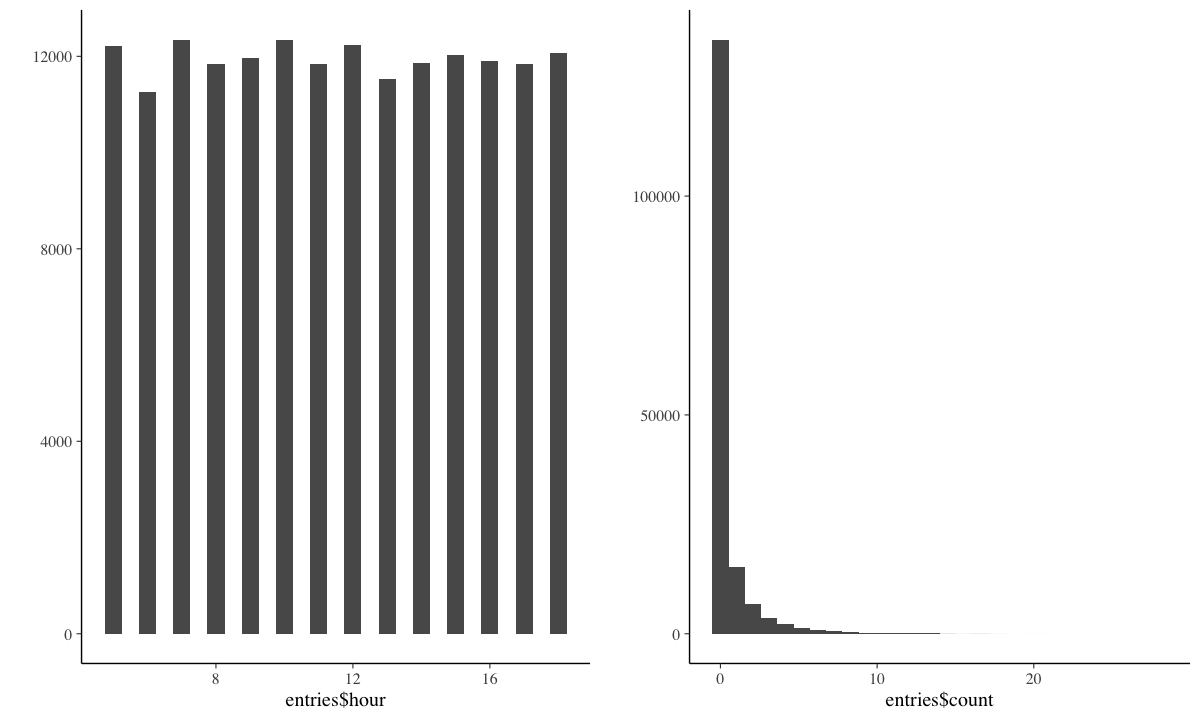

In [14]:
gridExtra::grid.arrange(
    qplot(entries$hour, bins=27),
    qplot(entries$count, bins=max(entries$count)),
nrow=1)

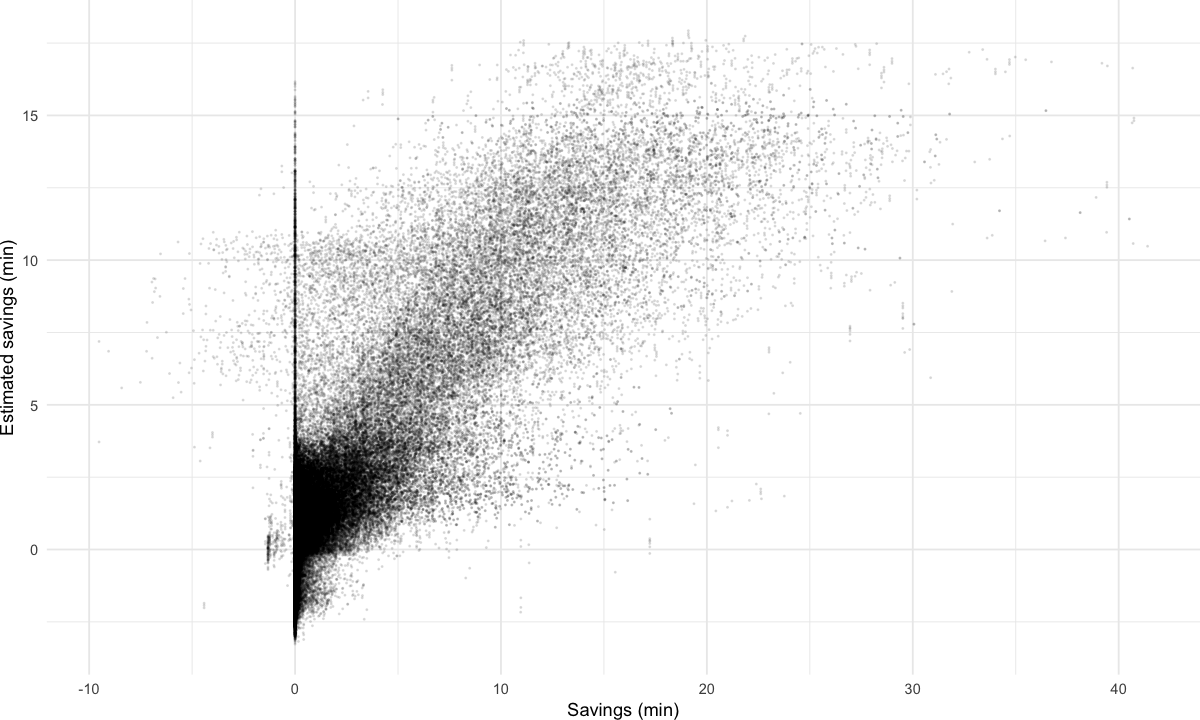

In [105]:
ggplot(entries, aes(60*savings, 60*est_savings)) +
    geom_point(alpha=0.1, size=0.2) +
    labs(x="Savings (min)", y="Estimated savings (min)") +
    theme_minimal() +
    theme(plot.margin=grid::unit(c(0,0,0,0), "mm"))

In [106]:
ggsave("../../../img/savings_est.png", width=6.5, height=4, dpi=320)

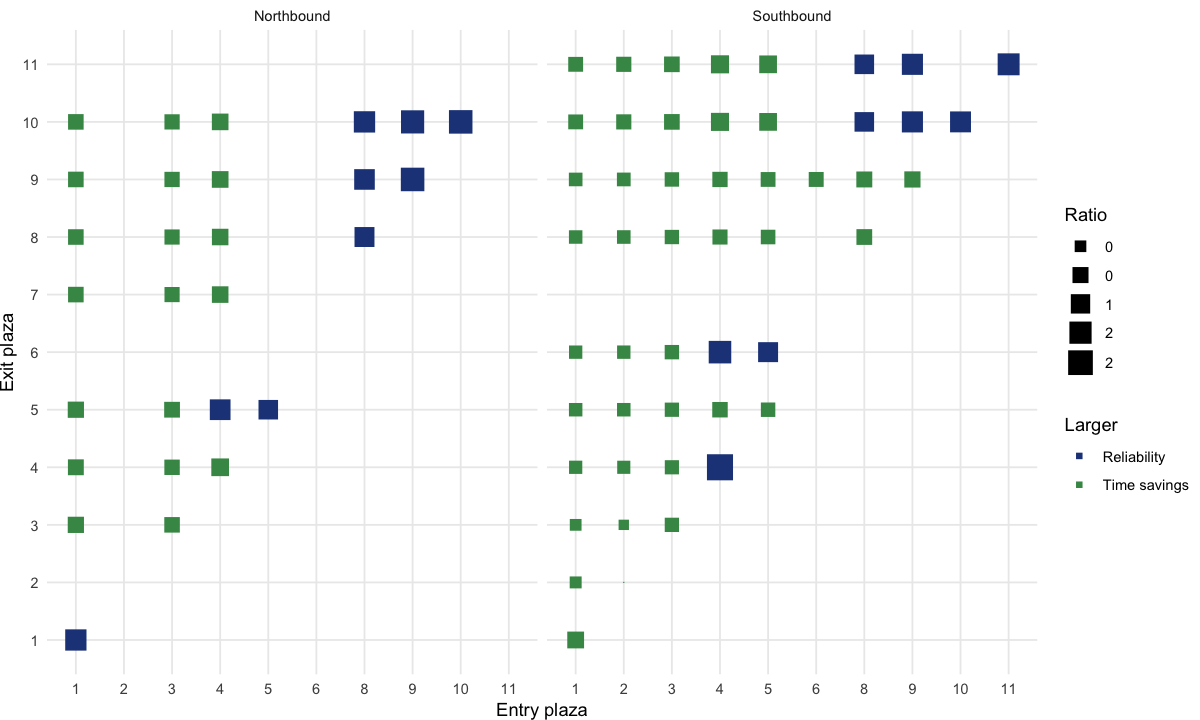

In [238]:
entries %>%
    filter(peak) %>%
    select(trip_id, entry, exit, direction, reliability, savings) %>%
    group_by(trip_id, entry, exit, direction) %>%
    summarize(ratio = mean(reliability)/mean(savings)) %>%
    ungroup() %>%
    mutate(entry = if_else(direction == "NB", entry-2, entry-12),
           exit = if_else(direction == "NB", exit-2, exit-12),
           direction = if_else(direction == "NB", "Northbound", "Southbound"),
           import = if_else(ratio > 1, "Reliability", "Time savings")) %>%
ggplot(aes(as_factor(entry), as_factor(exit), color=import, size=ratio)) +
    facet_wrap("direction") +
    geom_point(shape=15) + 
    scale_color_manual(values=c("#224488", "#449555")) +
    scale_size_continuous(labels=scales::number, range=c(0, 7)) +
    #guides(color=F) +
    labs(size="Ratio", color="Larger", x="Entry plaza", y="Exit plaza") +
    theme_minimal() +
    theme(plot.margin=grid::unit(c(0,0,0,0), "mm"))

In [114]:
ggsave("../../../img/trip_rel.png", width=6.5, height=3, dpi=320)

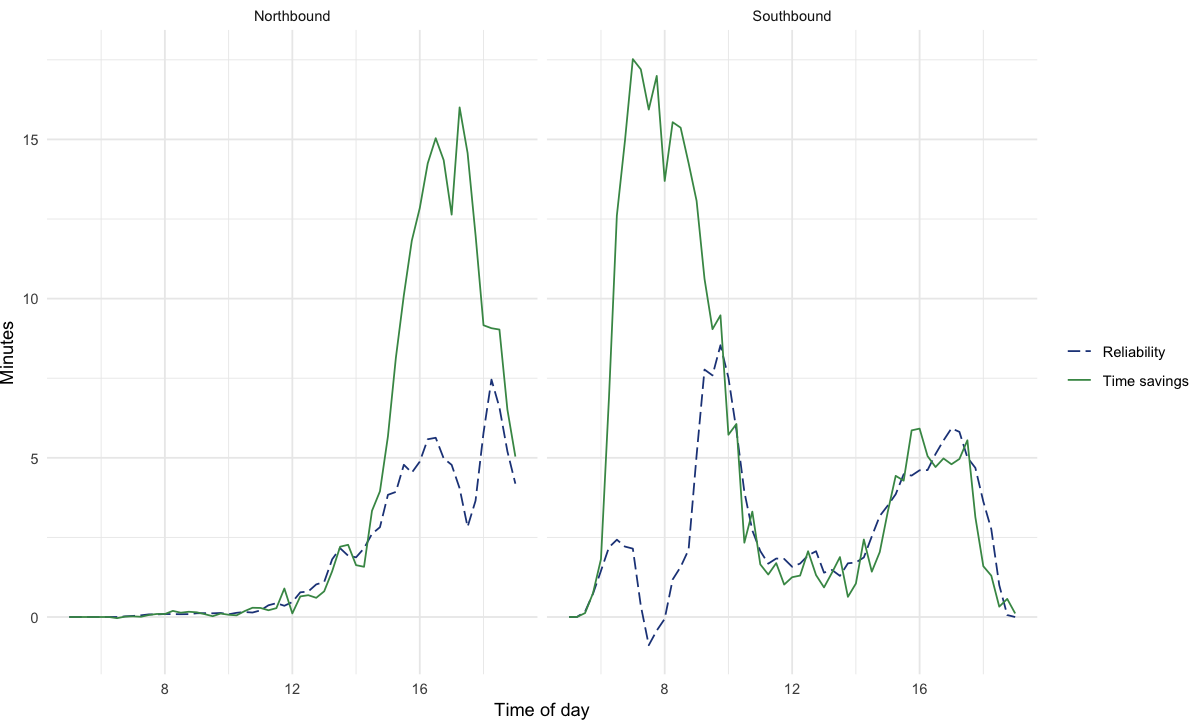

In [242]:
entries %>%
    filter((entry==3 & exit==12) | (entry == 13 & exit == 22)) %>%
    mutate(direction = if_else(entry==3, "Northbound", "Southbound"),
           hour = floor(tod/100) + round((tod %% 100)/15)/4) %>%
    select(hour, reliability, `time savings`=savings, direction) %>%
    group_by(hour, direction) %>%
    summarize_all(function(x) 60*mean(x)) %>%
    gather(qty, est, `time savings`, reliability) %>%
    mutate(qty = str_to_sentence(qty)) %>%
ggplot(aes(hour, est, color=qty, lty=qty)) + 
    facet_wrap("direction") +
    geom_line() +
    labs(x="Time of day", y="Minutes", color="") +
    scale_linetype_manual("", values=c("longdash", "solid")) +
    scale_color_manual(values=c("#224488", "#449555")) +
    theme_minimal() +
    theme(plot.margin=grid::unit(c(0,0,0,0), "mm"))

ggsave("../../../img/savings_reliability.png", width=6.5, height=3.5, dpi=320)

## Regression

In [13]:
est_values = function(m, d) {
    d2 = mutate(d,
        GP_volume = 0,
        GP_speed = 0,
        HOT_volume = 0,
        HOT_speed = 0,
        is.holiday = F,
        entry = 3,
        trip_length = 5,
        est_savings = 0,
        reliability = 0,
        toll = 0) 
    
    baseline = predict(m, newdata=d2)
    
    d2$est_savings=1
    savings = predict(m, newdata=d2) - baseline
    
    d2$est_savings=0
    d2$reliability=1
    reliability = predict(m, newdata=d2) - baseline
    
    d2$reliability=0
    d2$toll=1
    toll = predict(m, newdata=d2) - baseline
    
    d$VOT = -savings / toll
    d$VOR = -reliability / toll
    d$elasticity = toll * mean(entries$toll) / mean(entries$count)
    
    d
}

In [14]:
summary(entries$GP_volume)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00   53.07   64.23   64.38   76.76  118.02 

### Collinearity

In [15]:
select(entries, count, savings, est_savings, reliability, toll, 
       GP_speed, HOT_speed, GP_volume, HOT_volume, trip_length) %>%
cor %>%
round(2)

,count,savings,est_savings,reliability,toll,GP_speed,HOT_speed,GP_volume,HOT_volume,trip_length
count,1.00,0.18,0.19,0.18,0.10,-0.14,-0.03,0.10,0.19,0.09
savings,0.18,1.00,0.83,0.45,0.74,-0.52,-0.37,-0.15,0.29,0.32
est_savings,0.19,0.83,1.00,0.46,0.90,-0.62,-0.45,-0.18,0.35,0.39
reliability,0.18,0.45,0.46,1.00,0.27,-0.14,-0.06,-0.03,0.21,0.39
toll,0.10,0.74,0.90,0.27,1.00,-0.65,-0.58,-0.21,0.31,0.19
GP_speed,-0.14,-0.52,-0.62,-0.14,-0.65,1.00,0.56,0.15,-0.44,-0.06
HOT_speed,-0.03,-0.37,-0.45,-0.06,-0.58,0.56,1.00,0.24,-0.13,-0.07
GP_volume,0.10,-0.15,-0.18,-0.03,-0.21,0.15,0.24,1.00,0.39,-0.05
HOT_volume,0.19,0.29,0.35,0.21,0.31,-0.44,-0.13,0.39,1.00,-0.10
trip_length,0.09,0.32,0.39,0.39,0.19,-0.06,-0.07,-0.05,-0.10,1.00


### Baseline model

In [100]:
m = lm(count ~ (toll + est_savings + reliability) + GP_speed + GP_volume + HOT_volume + trip_length + is.holiday, 
       data=entries)
       #data=mutate(entries, est_savings=rnorm(length(savings), est_savings, 0.00001)))
summary(m)
est_values(m, tibble(group="Everyone"))


Call:
lm(formula = count ~ (toll + est_savings + reliability) + GP_speed + 
    GP_volume + HOT_volume + trip_length + is.holiday, data = entries)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.4231 -0.5317 -0.2760  0.0332 26.2884 

Coefficients:
                 Estimate Std. Error t value        Pr(>|t|)    
(Intercept)     0.2510578  0.0230254  10.904         < 2e-16 ***
toll           -0.1547921  0.0032457 -47.692         < 2e-16 ***
est_savings     8.2258201  0.1597848  51.481         < 2e-16 ***
reliability     4.0829359  0.1504023  27.147         < 2e-16 ***
GP_speed       -0.0068644  0.0003368 -20.384         < 2e-16 ***
GP_volume       0.0064707  0.0002284  28.329         < 2e-16 ***
HOT_volume      0.0071935  0.0003329  21.609         < 2e-16 ***
trip_length    -0.0057791  0.0008841  -6.537 0.0000000000631 ***
is.holidayTRUE -0.1044094  0.0166505  -6.271 0.0000000003605 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 

group,VOT,VOR,elasticity
<chr>,<dbl>,<dbl>,<dbl>
Everyone,53.14107,26.37689,-0.6374774


In [16]:
summary(lm(log(count) ~ est_savings + reliability + GP_speed + GP_volume + 
           HOT_volume + trip_length + is.holiday + log(toll), data=filter(entries, count>0)))



Call:
lm(formula = log(count) ~ est_savings + reliability + GP_speed + 
    GP_volume + HOT_volume + trip_length + is.holiday + log(toll), 
    data = filter(entries, count > 0))

Residuals:
    Min      1Q  Median      3Q     Max 
-1.5407 -0.4719 -0.1355  0.4321  2.3830 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)    -0.0174859  0.0225572  -0.775    0.438    
est_savings     3.7496278  0.1416208  26.477   <2e-16 ***
reliability     3.1510095  0.1465685  21.499   <2e-16 ***
GP_speed       -0.0035476  0.0003209 -11.057   <2e-16 ***
GP_volume       0.0049737  0.0002710  18.350   <2e-16 ***
HOT_volume      0.0086409  0.0003369  25.651   <2e-16 ***
trip_length     0.0082287  0.0009806   8.392   <2e-16 ***
is.holidayTRUE  0.0126231  0.0285857   0.442    0.659    
log(toll)      -0.1956082  0.0091418 -21.397   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.6241 on 31508 degrees of freedom
Mul

In [27]:
tibble(toll_level = seq(0.75, 2, 0.25)) %>%
    rowwise() %>%
    mutate(avg_count = mean(filter(entries, (toll)==(toll_level))$count),
           total = sum(filter(entries, (toll)==(toll_level))$count),
           elasticity = coef(m)["toll"] * toll_level / avg_count)

toll_level,avg_count,total,elasticity
<dbl>,<dbl>,<dbl>,<dbl>
0.75,0.3389145,42973,-0.3394019
1.00,0.7036130,1149,-0.2179763
1.25,0.8333333,1195,-0.2300564
1.50,1.1323764,1420,-0.2031625
1.75,1.0383929,1163,-0.2584755
2.00,0.9414991,1030,-0.3258016


In [37]:
tibble(toll_level = seq(9.00, 10.00, 1)) %>%
    rowwise() %>%
    mutate(avg_count = mean(filter(entries, floor(toll)==floor(toll_level))$count),
           total = sum(filter(entries, floor(toll)==floor(toll_level))$count),
           elasticity = coef(m)["toll"] * toll_level / avg_count)

toll_level,avg_count,total,elasticity
<dbl>,<dbl>,<dbl>,<dbl>
9,0.6656614,1545,-2.073635
10,0.6732122,4594,-2.278196


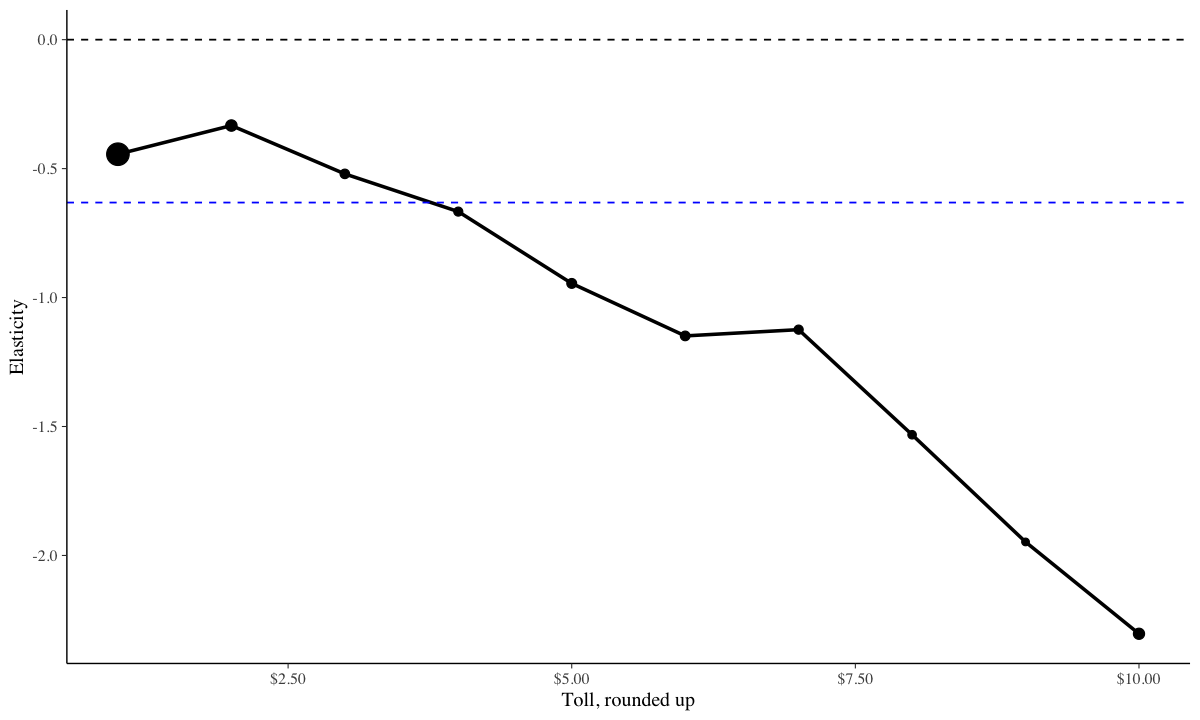

In [23]:
tibble(toll_level = seq(1, 10, 1)) %>%
    rowwise() %>%
    mutate(avg_count = mean(filter(entries, ceiling(toll)==toll_level)$count),
           total = sum(filter(entries, ceiling(toll)==toll_level)$count),
           elasticity = coef(m)["toll"] * toll_level / avg_count) %>%
qplot(toll_level, elasticity, size=total, data=.) + 
    geom_line(aes(size=0.5)) + 
    geom_hline(yintercept=0, lty="dashed") + 
    geom_hline(yintercept=est_values(m, tibble(group=""))$elasticity, lty="dashed", color="blue") + 
    scale_x_continuous(labels=scales::dollar, name="Toll, rounded up") +
    scale_y_continuous(name="Elasticity") +
    guides(size=F)

### Bootstrapping

In [471]:
fit.m = function(data, idx) coef(lm(m$call[[2]], data=data[idx,])) 

In [101]:
fit.m.values = function(data, idx) {
    mb = lm(m$call[[2]], data=data[idx,]) 
    vals = as.numeric(est_values(mb, tibble(group="Everyone"))[1,2:4])
    names(vals) = c("VOT", "VOR", "elasticity")
    vals
}

In [647]:
mb = boot(entries, statistic=fit.m, R=100, strata=entries$date_time)

In [648]:
left_join(broom::tidy(mb), broom::tidy(m), by=c("term", "statistic"="estimate")) %>%
    select(-statistic.y, -p.value) %>%
    mutate(ratio=std.error.x/std.error.y) %>%
    mutate_at(vars(-term), round, 4)

term,statistic,bias,std.error.x,std.error.y,ratio
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),0.2390,0.0041,0.0282,0.0229,1.2336
toll,-0.1549,-0.0004,0.0037,0.0032,1.1777
est_savings,8.2186,0.0111,0.1856,0.1565,1.1858
reliability,4.0779,0.0222,0.1489,0.1482,1.0046
GP_speed,-0.0068,-0.0001,0.0004,0.0003,1.3033
GP_volume,0.0066,0.0000,0.0001,0.0002,0.6512
HOT_volume,0.0068,0.0000,0.0003,0.0003,0.9927
trip_length,-0.0056,-0.0001,0.0008,0.0009,0.9602
is.holidayTRUE,-0.1253,0.0008,0.0083,0.0162,0.5109


In [649]:
gc()

,used,(Mb),gc trigger,(Mb),limit (Mb),max used,(Mb)
Ncells,3015805,161.1,8776477,468.8,NA,16164187,863.3
Vcells,54025374,412.2,170888905,1303.8,16384,222586298,1698.2


In [102]:
mb2 = boot(entries, statistic=fit.m.values, R=500, strata=entries$date_time)

In [ ]:
broom::tidy(mb2)

In [775]:
quantile(mb2$t[,1], c(0.005,0.5,0.995))

0.5%      50%    99.5% 
51.50645 53.12910 54.84795

In [104]:
m_est_values = as.data.frame(mb2$t)
names(m_est_values) = c("VOT", "VOR", "elasticity")
head(m_est_values)
write_csv(m_est_values, "../../data/benefits/est_vot_vor_elast.csv")

VOT,VOR,elasticity
<dbl>,<dbl>,<dbl>
52.01245,25.50951,-0.6559943
53.48999,26.97317,-0.6252146
53.47705,26.70832,-0.6132675
52.64017,26.71114,-0.6518958
53.75303,27.95511,-0.6203335
52.13573,26.68147,-0.6592390


In [748]:
broom::tidy(mb2)

term,statistic,bias,std.error
<chr>,<dbl>,<dbl>,<dbl>
VOT,53.0415344,0.02030893288,0.65685203
VOR,26.3182789,-0.02065332031,1.18984332
elasticity,-0.6379984,-0.00002411448,0.01494134


In [798]:
m_est_values %>%
    gather(param, est) %>%
    group_by(param) %>%
    group_modify(~ as.data.frame(t(quantile(.$est, c(0.025, 0.5, 0.975)))))

param,2.5%,50%,97.5%
<chr>,<dbl>,<dbl>,<dbl>
elasticity,-0.6629709,-0.6342215,-0.6013707
VOR,24.2645519,26.5138367,29.0092611
VOT,51.7124096,53.1291011,54.4464155


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


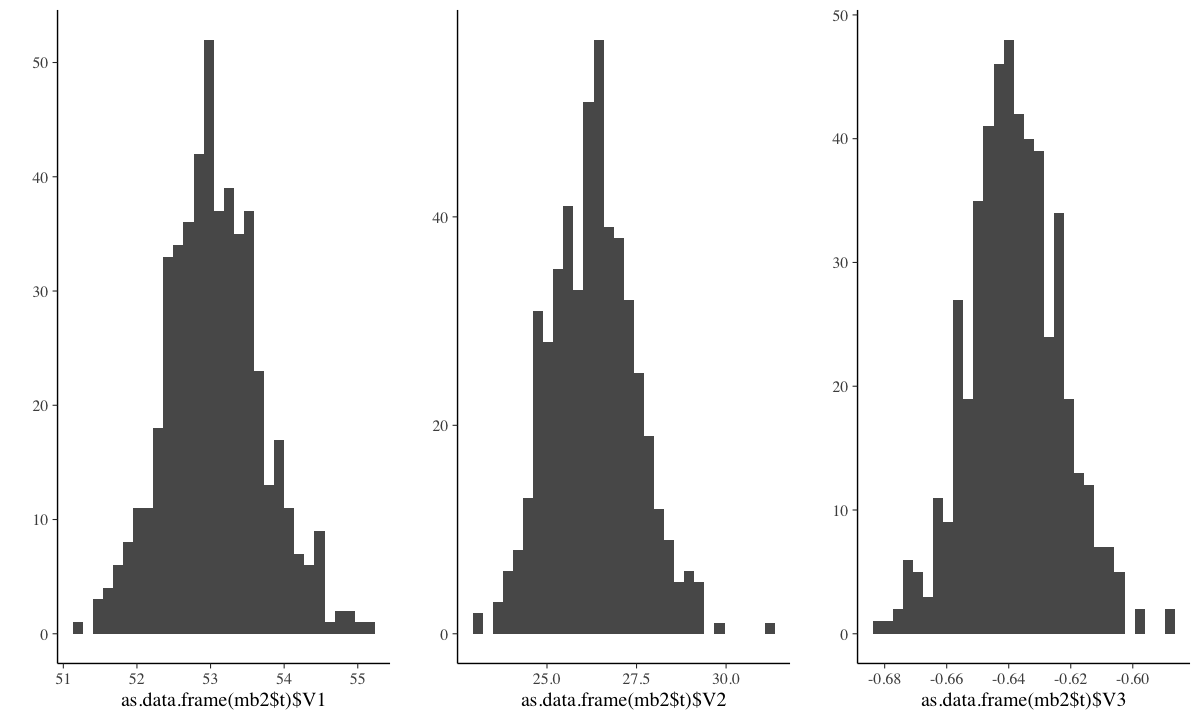

In [749]:
gridExtra::grid.arrange(
    qplot(as.data.frame(mb2$t)$V1),
    qplot(as.data.frame(mb2$t)$V2),
    qplot(as.data.frame(mb2$t)$V3),
nrow=1)

In [750]:
car::vif(m)

toll est_savings reliability    GP_speed   GP_volume  HOT_volume 
   6.501483    8.656545    1.572888    2.103328    1.515615    2.020691 
trip_length  is.holiday 
   1.577970    1.041892

### Bayesian

In [735]:
mby = stan_lm(count ~ (toll + est_savings + reliability) + GP_speed + 
              GP_volume + HOT_volume + trip_length + is.holiday, 
       data=entries, chains=1, iter=2000, prior=R2(location=0.5))


SAMPLING FOR MODEL 'lm' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 1.9e-05 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.19 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 1: Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 1: Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 1: Iteration:  600 / 2000 [ 30%]  (Warmup)
Chain 1: Iteration:  800 / 2000 [ 40%]  (Warmup)
Chain 1: Iteration: 1000 / 2000 [ 50%]  (Warmup)
Chain 1: Iteration: 1001 / 2000 [ 50%]  (Sampling)
Chain 1: Iteration: 1200 / 2000 [ 60%]  (Sampling)
Chain 1: Iteration: 1400 / 2000 [ 70%]  (Sampling)
Chain 1: Iteration: 1600 / 2000 [ 80%]  (Sampling)
Chain 1: Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain 1: Iteration: 2000 / 2000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 4.44304 seconds (Warm-up)
Chain 1:                3.8588 seconds (Sampling)
Chain 1:                8.30185 s

In [736]:
mby

stan_lm
 family:       gaussian [identity]
 formula:      count ~ (toll + est_savings + reliability) + GP_speed + GP_volume + 
	   HOT_volume + trip_length + is.holiday
 observations: 167837
 predictors:   9
------
               Median MAD_SD
(Intercept)     0.2    0.0  
toll           -0.2    0.0  
est_savings     8.2    0.1  
reliability     4.1    0.1  
GP_speed        0.0    0.0  
GP_volume       0.0    0.0  
HOT_volume      0.0    0.0  
trip_length     0.0    0.0  
is.holidayTRUE -0.1    0.0  

Auxiliary parameter(s):
              Median MAD_SD
R2            0.1    0.0   
log-fit_ratio 0.0    0.0   
sigma         1.3    0.0   

Sample avg. posterior predictive distribution of y:
         Median MAD_SD
mean_PPD 0.4    0.0   

------
* For help interpreting the printed output see ?print.stanreg
* For info on the priors used see ?prior_summary.stanreg

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


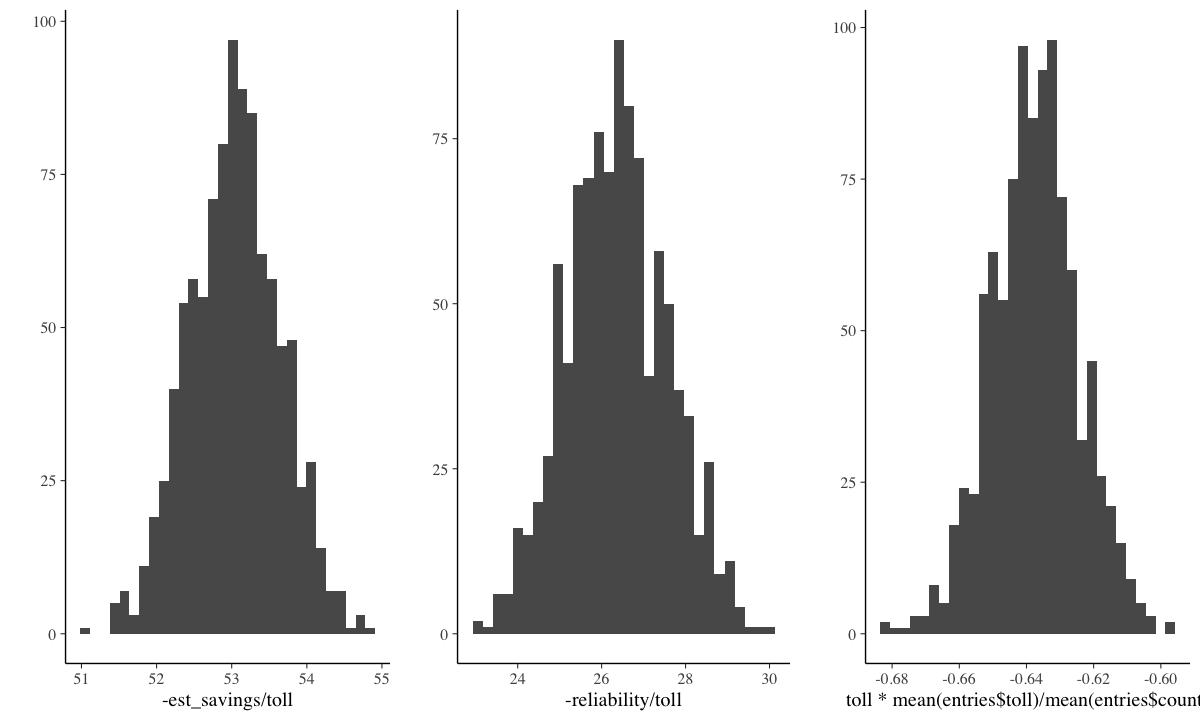

In [737]:
samples = as.data.frame(mby)[,1:9]
gridExtra::grid.arrange(
    qplot(-est_savings/toll, data=samples),
    qplot(-reliability/toll, data=samples),
    qplot(toll * mean(entries$toll)/mean(entries$count), data=samples),
nrow=1)

In [738]:
sd(samples$est_savings/samples$toll)

[1] 0.6028201

In [742]:
mean(bayes_R2(mby))

[1] 0.0833732

In [743]:
gc()

,used,(Mb),gc trigger,(Mb),limit (Mb),max used,(Mb)
Ncells,3347165,178.8,8776477,468.8,NA,16164187,863.3
Vcells,59315363,452.6,704743648,5376.8,16384,880920256,6720.9


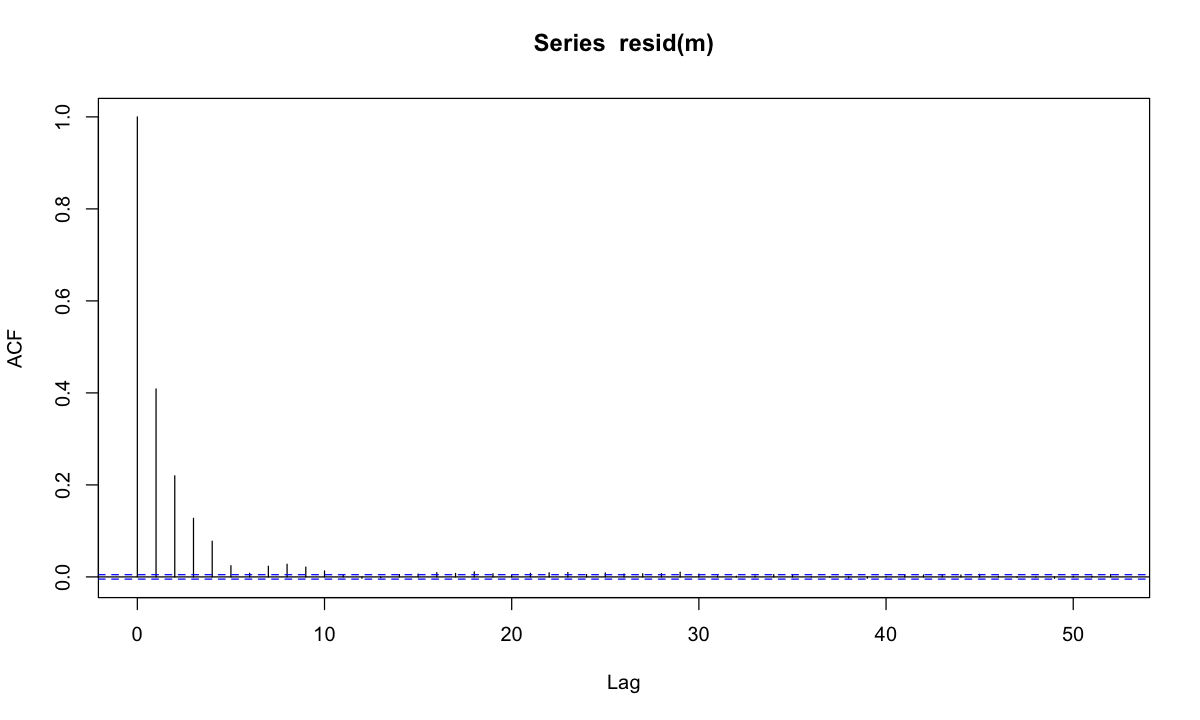

In [801]:
acf(resid(m))



---



## By time of day

In [245]:
m = lm(count ~ (toll + est_savings + reliability)*peak_group + GP_speed + GP_volume + trip_length, 
       data=entries)
       #data=mutate(entries, est_savings=savings))
summary(m)
#est_values(m, tibble(dir_group=unique(entries$peak_group)))
est_values(m, tibble(peak_group=unique(entries$peak_group)))


Call:
lm(formula = count ~ (toll + est_savings + reliability) * peak_group + 
    GP_speed + GP_volume + trip_length, data = entries)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.4991 -0.4913 -0.2673 -0.0081 25.9676 

Coefficients:
                                        Estimate Std. Error t value Pr(>|t|)
(Intercept)                            0.5001083  0.0257912  19.391  < 2e-16
toll                                  -0.1987295  0.0062089 -32.007  < 2e-16
est_savings                            9.3109529  0.3009427  30.939  < 2e-16
reliability                            9.3535212  0.4673664  20.013  < 2e-16
peak_groupOff-peak                    -0.1375903  0.0133343 -10.319  < 2e-16
peak_groupPM peak NB                   0.3391044  0.0243990  13.898  < 2e-16
peak_groupReverse commute             -0.2534002  0.0159796 -15.858  < 2e-16
GP_speed                              -0.0092343  0.0003201 -28.848  < 2e-16
GP_volume                              0.0076485  0.0002017  37

peak_group,VOT,VOR,elasticity
<chr>,<dbl>,<dbl>,<dbl>
Reverse commute,389.08893,1524.52943,-0.0169329
AM peak SB,46.85239,47.06659,-0.8184238
Off-peak,54.41784,21.37450,-0.4949619
PM peak NB,43.38796,18.42815,-1.0364608


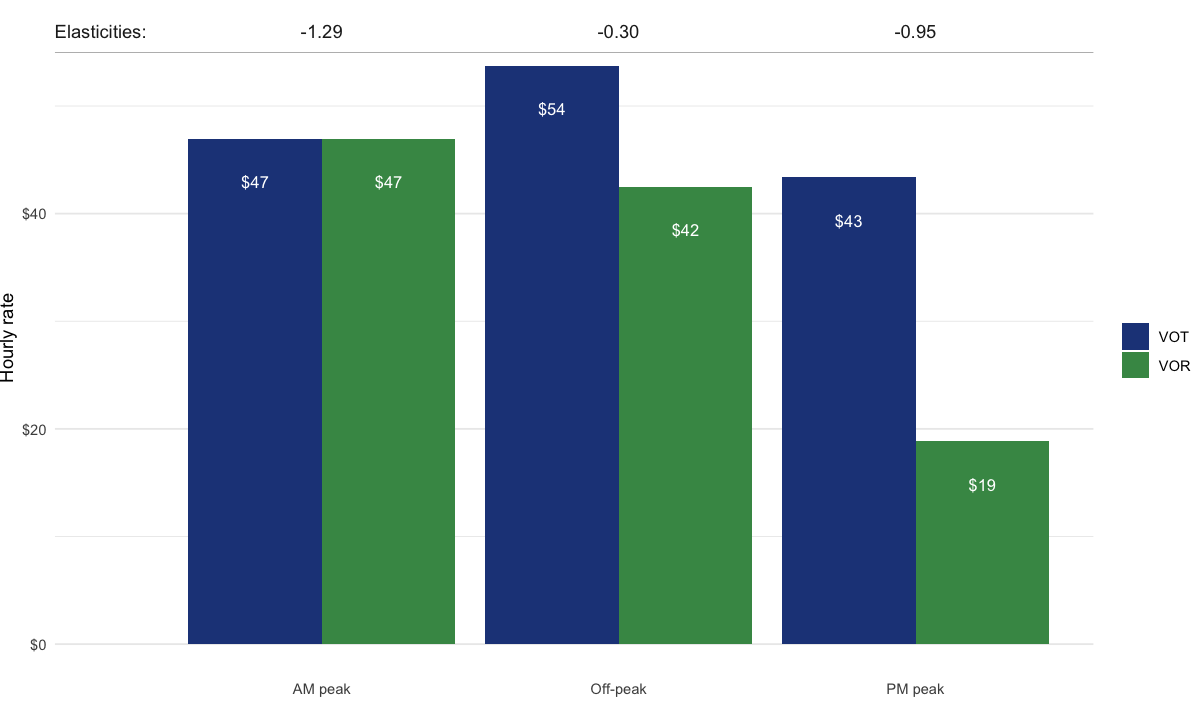

In [236]:
entries %>%
    mutate(wrong_factor = mean(toll)/mean(count)) %>%
    group_by(dir_group) %>%
    summarize(correction = (1/mean(wrong_factor))*mean(toll)/mean(count)) %>%
    left_join(est_values(m, tibble(dir_group=unique(entries$peak_group))), by="dir_group") %>%
    mutate(elasticity = correction*elasticity) %>%
    select(-correction) %>%
    gather(par, est, VOT, VOR) %>%
    arrange(desc(par)) %>%
    mutate(elasticity = ifelse(par=="VOT", sprintf("%.02f", elasticity), ""))  %>%
ggplot(aes(dir_group, est, fill=reorder(par, -est))) +
    geom_col(position="dodge") +
    scale_fill_manual(values=c("#224488", "#449555")) +
    labs(x="", y="Hourly rate", fill="") +
    geom_text(aes(y=est-4, label=scales::dollar(round(est))), position=position_dodge(width=0.9), color="white", size=3.5) +
    geom_text(aes(y=57, label=elasticity), color="#222222") +
    annotate("text", x=0.1, y=57, label="Elasticities:", hjust="left", color="#222222") +
    geom_hline(yintercept=55, color="#222222", lwd=0.1) +
    scale_y_continuous(labels=scales::dollar) +
    theme_minimal() +
    theme(panel.grid.major.x = element_blank(),
          panel.grid.minor.x = element_blank(),
          plot.margin=grid::unit(c(0,0,0,0), "mm"))

ggsave("../../../img/est_tod.png", width=6.5, height=3.5, dpi=320)

In [156]:
boot_names = est_values(m, tibble(dir_group=c("AM peak", "Off-peak", "PM peak"))) %>%
    gather(par, est, -dir_group) %>%
    mutate(par = paste(dir_group, par)) %>%
    select(par, est) %>%
    spread(par, est) %>% 
    colnames

In [157]:
boot_names

[1] "AM peak elasticity"  "AM peak VOR"         "AM peak VOT"        
[4] "Off-peak elasticity" "Off-peak VOR"        "Off-peak VOT"       
[7] "PM peak elasticity"  "PM peak VOR"         "PM peak VOT"

In [153]:
fit.m.values = function(data, idx) {
    mb = lm(m$call[[2]], data=data[idx,]) 
    vals = est_values(m, tibble(dir_group=c("AM peak", "Off-peak", "PM peak"))) %>%
        gather(par, est, -dir_group) %>%
        mutate(par = paste(dir_group, par)) %>%
        select(par, est) %>%
        spread(par, est) %>% 
        as.numeric
    vals
}

In [200]:
mb3 = boot(entries, statistic=fit.m.values, R=1, strata=entries$date_time)

## By income (experimental)

In [659]:
mean(filter(entries, inc>0)$inc, na.rm=T)

[1] 122.2352

In [660]:
#m2 = lm(count ~ GP_speed + GP_volume + (est_savings + reliability + toll)*(inc + peak_group), data=drop_na(entries, inc))
m2 = lm(count ~ GP_speed + GP_volume + HOT_speed + trip_length + (est_savings + reliability + toll)*(inc), 
        #data=filter(entries, inc > 0, peak_group != "Off-peak"))
        #data=filter(entries, inc > 0))
        data=mutate(entries, inc = if_else(inc==0, 122.24, inc)))
summary(m2)
est_values(m2, tibble(inc=c(50,75,100,150)))


Call:
lm(formula = count ~ GP_speed + GP_volume + HOT_speed + trip_length + 
    (est_savings + reliability + toll) * (inc), data = mutate(entries, 
    inc = if_else(inc == 0, 122.24, inc)))

Residuals:
    Min      1Q  Median      3Q     Max 
-2.4397 -0.5037 -0.2686  0.0034 24.7890 

Coefficients:
                  Estimate Std. Error t value         Pr(>|t|)    
(Intercept)     -0.1382614  0.0499471  -2.768          0.00564 ** 
GP_speed        -0.0098454  0.0003382 -29.111          < 2e-16 ***
GP_volume        0.0093039  0.0001914  48.603          < 2e-16 ***
HOT_speed        0.0004308  0.0005922   0.728          0.46689    
trip_length     -0.0121843  0.0008367 -14.562          < 2e-16 ***
est_savings      9.4772180  1.0960315   8.647          < 2e-16 ***
reliability      6.7460325  1.0423019   6.472 0.00000000009683 ***
toll             0.1682547  0.0242065   6.951 0.00000000000365 ***
inc              0.0037601  0.0002804  13.410          < 2e-16 ***
est_savings:inc -0.0035502  

inc,VOT,VOR,elasticity
<dbl>,<dbl>,<dbl>,<dbl>
50,-315.14111,-198.84260,0.1215079
75,231.06619,136.18328,-0.1641377
100,83.50960,45.67684,-0.4497833
150,36.07016,16.57902,-1.0210745


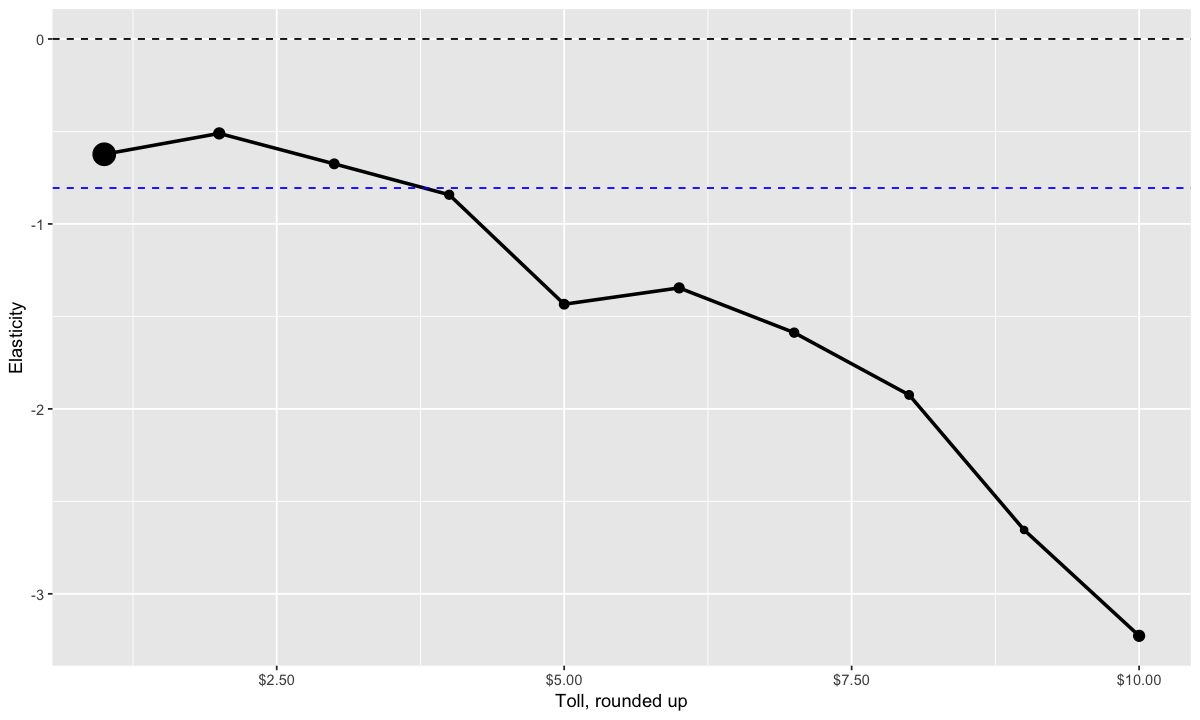

In [468]:
tibble(toll_level = 1:10) %>%
    rowwise() %>%
    mutate(avg_count = mean(filter(entries, ceiling(toll)==toll_level)$count),
           total = sum(filter(entries, ceiling(toll)==toll_level)$count),
           elasticity = coef(m2)["toll"] * toll_level / avg_count) %>%
qplot(toll_level, elasticity, size=total, data=.) + 
    geom_line(aes(size=0.5)) + 
    geom_hline(yintercept=0, lty="dashed") + 
    geom_hline(yintercept=est_values(m2, tibble(inc=100))$elasticity, lty="dashed", color="blue") + 
    scale_x_continuous(labels=scales::dollar, name="Toll, rounded up") +
    scale_y_continuous(name="Elasticity") +
    guides(size=F)

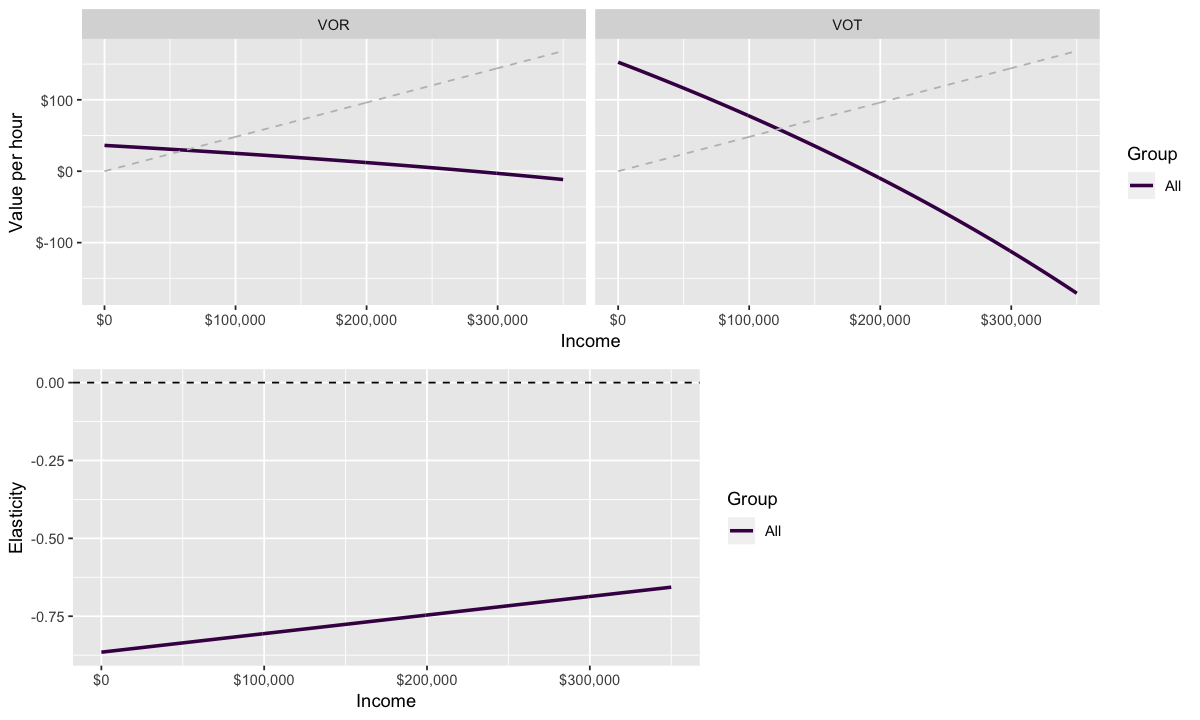

In [469]:
#pred.d = expand.grid(inc = 0:200, group=unique(entries$group))
#pred.d = expand.grid(inc = 0:140, peak_group=unique(entries$peak_group))
pred.d = expand.grid(inc = 0:350)
pred.d = est_values(m2, pred.d)
#pred.d = rename(pred.d, group=peak_group)
pred.d = mutate(pred.d, group="All")

p1 = filter(pred.d, group != "NB Off-peak") %>%
    select(-elasticity) %>%
    gather(benefit, value, VOT, VOR) %>%
    ggplot(aes(1000*inc, value, color=group, group=group)) +
    facet_wrap("benefit") +
    geom_line(size=1) + 
    scale_x_continuous(labels=scales::dollar, name="Income") +
    scale_y_continuous(labels=scales::dollar, name="Value per hour") +
    geom_line(aes(y=inc/2.080), lty="dashed", color="grey") +
    scale_color_viridis_d() +
    labs(color="Group")

p3 = filter(pred.d, group != "NB Off-peak") %>%
    ggplot(aes(1000*inc, elasticity, color=group, group=group)) +
    geom_line(size=1) + 
    scale_x_continuous(labels=scales::dollar, name="Income") +
    scale_y_continuous(name="Elasticity") +
    geom_hline(yintercept=0, lty="dashed") +
    #geom_hline(yintercept=-1, lty="dashed") +
    scale_color_viridis_d() +
    labs(color="Group")
            
gridExtra::grid.arrange(p1, p3, layout_matrix=rbind(c(1,1,1),c(2,2,NA)))